In [2]:
import pandas as pd
import numpy as np
import math as maths
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import FancyArrow
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
from numpy.linalg import eig
from matplotlib import ticker, cm
from scipy import interpolate
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
from pathlib import Path  
style.use('default') or plt.style.use('default')
import seaborn as sns
from decimal import Decimal


In [3]:
# Constants

# Note: RateFac1 and ActEnergy1 correspond with the colder 
# (generally higher elevation) ice

RateFac1_n3 = Decimal(1.258e13)
RateFac2_n3 = Decimal(6.046e28)

ActEnergy1_n3 = Decimal(60e3)
ActEnergy2_n3 = Decimal(139e3)

R = Decimal(8.314) # Universal gas constant


In [4]:
# Calculate the corresponding constants for an n=4 power law

# Assumption: the activation energy remains the same

RateFac1_n4 = Decimal(RateFac1_n3 / Decimal(0.25))

RateFac2_n4 = Decimal((RateFac1_n4 * np.exp(-((ActEnergy1_n3 - ActEnergy2_n3)/(R * Decimal(263.15))))))


In [5]:
"{:e}".format(RateFac1_n4), "{:e}".format(RateFac2_n4)

('5.03200000000e+13', '2.418891369807408489937492964e+29')

In [6]:
6.047228e+28, 2.418891e+29

(6.047228e+28, 2.418891e+29)

In [7]:
# Define a function to calculate A for a certain temperature

def A(A0, Q, T):
    A0 = Decimal(A0)
    Q = Decimal(Q)
    T = Decimal(T)
    A = A0 * np.exp(- Q / (R * T))
    return A


In [8]:
# Define range for temperature segments (warm and cold ice)

Temps_w = np.linspace(263.15, 273.15, 100)
Temps_c = np.linspace(233.15, 263.15, 301)

# Store values for warmer and colder ice for n=3 and n=4

A_n3_w = []
A_n3_c = []
A_n4_w = []
A_n4_c = []


In [9]:
# Calculate A in a for loop

yearinsec = Decimal(365.25*24*60*60)

for T in Temps_w:
    A_n3_w.append(Decimal(A(RateFac2_n3, ActEnergy2_n3, T)))
    A_n4_w.append(Decimal(A(RateFac2_n4, ActEnergy2_n3, T)))
    #A_n3_w.append(Decimal(A(RateFac2_n3, ActEnergy2_n3, T) / (yearinsec * Decimal(1e18))))
    #A_n4_w.append(Decimal(A(RateFac2_n4, ActEnergy2_n3, T) / (yearinsec * Decimal(1e24))))

for T in Temps_c:
    A_n3_c.append(Decimal(A(RateFac1_n3, ActEnergy1_n3, T)))
    A_n4_c.append(Decimal(A(RateFac1_n4, ActEnergy1_n3, T)))
    #A_n3_c.append(Decimal(A(RateFac1_n3, ActEnergy1_n3, T) / (yearinsec * Decimal(1e18))))
    #A_n4_c.append(Decimal(A(RateFac1_n4, ActEnergy1_n3, T) / (yearinsec * Decimal(1e24))))


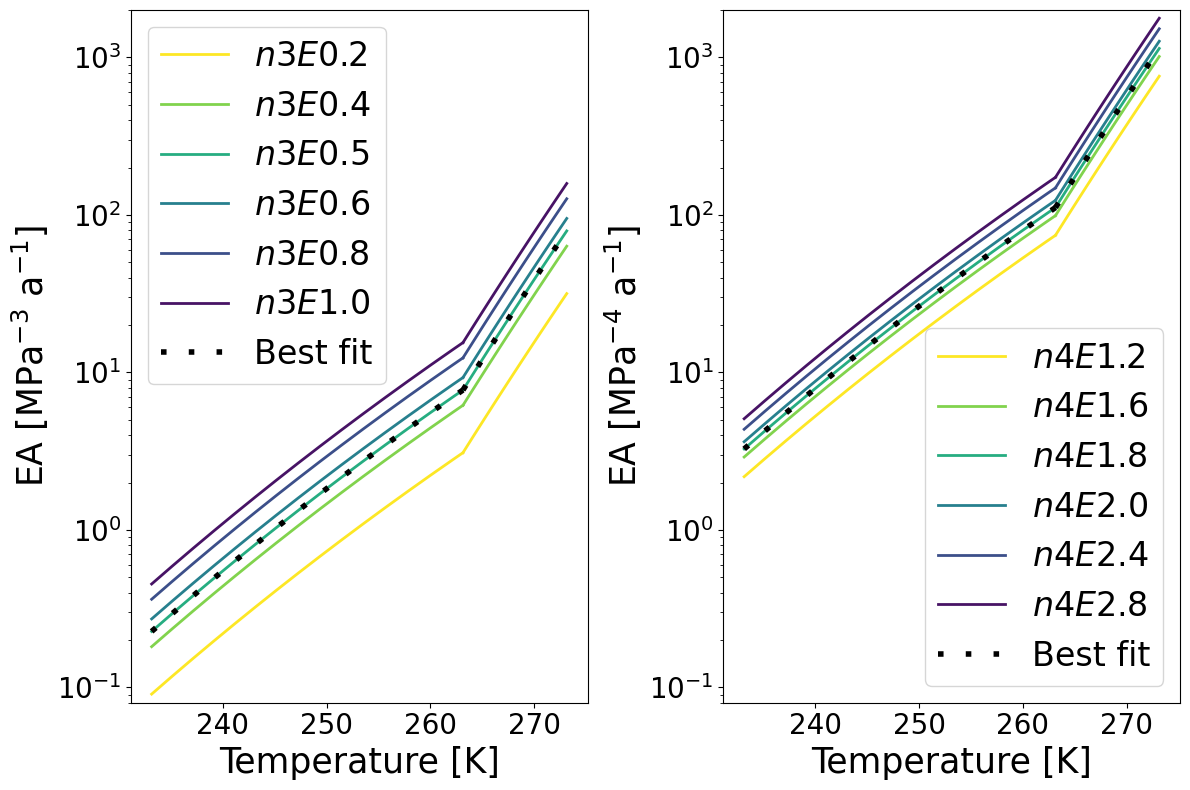

In [15]:

colors = plt.cm.viridis_r(np.linspace(0,0.95,6))
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
E_n3 = [0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
E_n4 = [1.2, 1.6, 1.8, 2.0, 2.4, 2.8]
for i in range(len(E_n3)):
    ax[0].plot(Temps_w, [j * Decimal(E_n3[i]) for j in A_n3_w], linewidth=2.0, color=colors[i], label=r'$n3E$' + str(E_n3[i]))
    ax[0].plot(Temps_c, [j * Decimal(E_n3[i]) for j in A_n3_c], linewidth=2.0, color=colors[i])
for i in range(len(E_n4)):
    ax[1].plot(Temps_w, [j * Decimal(E_n4[i]) for j in A_n4_w], linewidth=2.0, color=colors[i], label=r'$n4E$' + str(E_n4[i]))
    ax[1].plot(Temps_c, [j * Decimal(E_n4[i]) for j in A_n4_c], linewidth=2.0, color=colors[i])

ax[0].plot(Temps_w, [j * Decimal(0.5) for j in A_n3_w], color='black', linewidth=4.0, linestyle=(0, (1, 4)), label='Best fit')
ax[0].plot(Temps_c, [j * Decimal(0.5) for j in A_n3_c], color='black', linewidth=4.0, linestyle=(0, (1, 4)))
ax[1].plot(Temps_w, [j * Decimal(1.8) for j in A_n4_w], color='black', linewidth=4.0, linestyle=(0, (1, 4)), label='Best fit')
ax[1].plot(Temps_c, [j * Decimal(1.8) for j in A_n4_c], color='black', linewidth=4.0, linestyle=(0, (1, 4)))
ax[0].set_xlabel(r'Temperature [K]', size=25)
ax[1].set_xlabel(r'Temperature [K]', size=25)
ax[0].set_ylabel(r'EA [MPa$^{-3}$ a$^{-1}]$', size=25)
ax[1].set_ylabel(r'EA [MPa$^{-4}$ a$^{-1}]$', size=25)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[0].legend(fontsize = 24)
ax[1].legend(fontsize = 24, loc="lower right")
ax[0].set_ylim([0.08, 2000])
ax[1].set_ylim([0.08, 2000])
plt.tight_layout()

fig.savefig('../Figures/EA.jpg', format='jpg', dpi=700, bbox_inches = "tight")


In [11]:
# Plot the EA(n=4) / EA(n=3)

Div_w = []
Div_c = []

for i in range(len(A_n3_w)):
    Div_w.append((Decimal(1.8) * A_n4_w[i]) / (Decimal(0.5) * A_n3_w[i]))
for i in range(len(A_n3_c)):
    Div_c.append((Decimal(1.8) * A_n4_c[i]) / (Decimal(0.5) * A_n3_c[i]))

Div_w[0], Div_c[0]

(Decimal('14.40292578780461624022397650'),
 Decimal('14.40000000000000035527136788'))